[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'AAPL Price'}, xlabel='Date'>

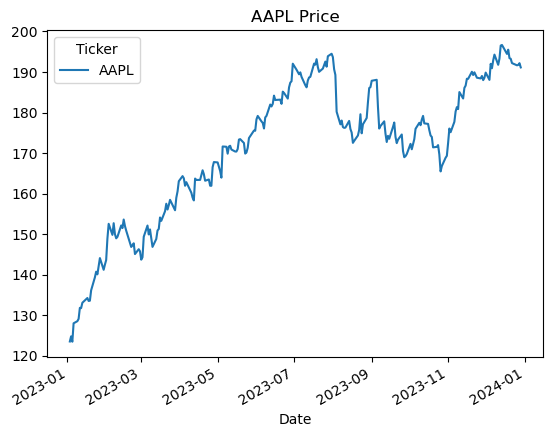

In [4]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

# Download historical price data
ticker = "AAPL"
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")
data = data['Close']
data.plot(title=f"{ticker} Price")

In [6]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(price, S, K, T, r, option_type='call'):
    func = lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - price
    return brentq(func, 1e-6, 5)